In [1]:
import numpy as np
import pandas as pd
import os, sys, gc, warnings, random, datetime, math, re

from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('..')
from utils import *
warnings.filterwarnings('ignore')

In [2]:
TARGET = 'isFraud'
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
SEED = 42
lgb_params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':80000,
                    'max_bin':255,
                    'verbose':100,
                    'seed': SEED,
                    'early_stopping_rounds':100, 
                } 

In [3]:
def values_normalization(dt_df, periods, columns):
    for period in periods:
        for col in columns:
            new_col = col +'_'+ period
            dt_df[col] = dt_df[col].astype(float)  

            temp_min = dt_df.groupby([period])[col].agg(['min']).reset_index()
            temp_min.index = temp_min[period].values
            temp_min = temp_min['min'].to_dict()

            temp_max = dt_df.groupby([period])[col].agg(['max']).reset_index()
            temp_max.index = temp_max[period].values
            temp_max = temp_max['max'].to_dict()

            temp_mean = dt_df.groupby([period])[col].agg(['mean']).reset_index()
            temp_mean.index = temp_mean[period].values
            temp_mean = temp_mean['mean'].to_dict()

            temp_std = dt_df.groupby([period])[col].agg(['std']).reset_index()
            temp_std.index = temp_std[period].values
            temp_std = temp_std['std'].to_dict()

            dt_df['temp_min'] = dt_df[period].map(temp_min)
            dt_df['temp_max'] = dt_df[period].map(temp_max)
            dt_df['temp_mean'] = dt_df[period].map(temp_mean)
            dt_df['temp_std'] = dt_df[period].map(temp_std)

            dt_df[new_col+'_min_max'] = (dt_df[col]-dt_df['temp_min'])/(dt_df['temp_max']-dt_df['temp_min'])
            dt_df[new_col+'_std_score'] = (dt_df[col]-dt_df['temp_mean'])/(dt_df['temp_std'])
            del dt_df['temp_min'],dt_df['temp_max'],dt_df['temp_mean'],dt_df['temp_std']
    return dt_df

In [4]:
def frequency_encoding(train_df, test_df, columns, self_encoding=False):
    for col in columns:
        temp_df = pd.concat([train_df[[col]], test_df[[col]]])
        fq_encode = temp_df[col].value_counts(dropna=False).to_dict()
        if self_encoding:
            train_df[col] = train_df[col].map(fq_encode)
            test_df[col]  = test_df[col].map(fq_encode)            
        else:
            train_df[col+'_fq_enc'] = train_df[col].map(fq_encode)
            test_df[col+'_fq_enc']  = test_df[col].map(fq_encode)
    return train_df, test_df

In [5]:
def timeblock_frequency_encoding(train_df, test_df, periods, columns, 
                                 with_proportions=True, only_proportions=False):
    for period in periods:
        for col in columns:
            new_col = col +'_'+ period
            train_df[new_col] = train_df[col].astype(str)+'_'+train_df[period].astype(str)
            test_df[new_col]  = test_df[col].astype(str)+'_'+test_df[period].astype(str)

            temp_df = pd.concat([train_df[[new_col]], test_df[[new_col]]])
            fq_encode = temp_df[new_col].value_counts().to_dict()

            train_df[new_col] = train_df[new_col].map(fq_encode)
            test_df[new_col]  = test_df[new_col].map(fq_encode)
            
            if only_proportions:
                train_df[new_col] = train_df[new_col]/train_df[period+'_total']
                test_df[new_col]  = test_df[new_col]/test_df[period+'_total']

            if with_proportions:
                train_df[new_col+'_proportions'] = train_df[new_col]/train_df[period+'_total']
                test_df[new_col+'_proportions']  = test_df[new_col]/test_df[period+'_total']

    return train_df, test_df

In [6]:
def uid_aggregation(train_df, test_df, main_columns, uids, aggregations):
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = col+'_'+main_column+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name]  = test_df[col].map(temp_df)
    return train_df, test_df

def uid_aggregation_and_normalization(train_df, test_df, main_columns, uids, aggregations):
    for main_column in main_columns:  
        for col in uids:
            
            new_norm_col_name = col+'_'+main_column+'_std_norm'
            norm_cols = []
            
            for agg_type in aggregations:
                new_col_name = col+'_'+main_column+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name]  = test_df[col].map(temp_df)
                norm_cols.append(new_col_name)
            
            train_df[new_norm_col_name] = (train_df[main_column]-train_df[norm_cols[0]])/train_df[norm_cols[1]]
            test_df[new_norm_col_name]  = (test_df[main_column]-test_df[norm_cols[0]])/test_df[norm_cols[1]]          
            
            del train_df[norm_cols[0]], train_df[norm_cols[1]]
            del test_df[norm_cols[0]], test_df[norm_cols[1]]
                                              
    return train_df, test_df

In [7]:
def check_cor_and_remove(train_df, test_df, i_cols, new_columns, remove=False):
    # Check correllation
    print('Correlations','#'*10)
    for col in new_columns:
        cor_cof = np.corrcoef(train_df[TARGET], train_df[col].fillna(0))[0][1]
        print(col, cor_cof)

    if remove:
        print('#'*10)
        print('Best options:')
        best_fe_columns = []
        for main_col in i_cols:
            best_option = ''
            best_cof = 0
            for col in new_columns:
                if main_col in col:
                    cor_cof = np.corrcoef(train_df[TARGET], train_df[col].fillna(0))[0][1]
                    cor_cof = (cor_cof**2)**0.5
                    if cor_cof>best_cof:
                        best_cof = cor_cof
                        best_option = col

            print(main_col, best_option, best_cof)            
            best_fe_columns.append(best_option)

        for col in new_columns:
            if col not in best_fe_columns:
                del train_df[col], test_df[col]

    return train_df, test_df

In [8]:
print('Load Data')
train_df = pd.read_pickle('../input/train_transaction.pkl')
test_df = pd.read_pickle('../input/test_transaction.pkl')
train_identity = pd.read_pickle('../input/train_identity.pkl')
test_identity = pd.read_pickle('../input/test_identity.pkl')

print('Shape control:', train_df.shape, test_df.shape)

Load Data
Shape control: (590540, 394) (506691, 394)


In [9]:
remove_features = [
    'TransactionID','TransactionDT', # These columns are pure noise right now
    TARGET,
    ]

base_columns = [col for col in list(train_df) if col not in remove_features]

In [30]:
lgb_params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':80000,
                    'max_bin':255,
                    'seed': SEED,
                    'early_stopping_rounds':100, 
                    'reg_alpha': 0.1,
                    'reg_lambda': 0.1,
                } 
features = [x for x in base_columns if train_df[x].dtype != 'object']
local_valid(train_df, 'isFraud', features, lgb_params, return_model=False)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.932763	valid_1's auc: 0.8882
[200]	training's auc: 0.950862	valid_1's auc: 0.900245
[300]	training's auc: 0.966219	valid_1's auc: 0.909486
[400]	training's auc: 0.976985	valid_1's auc: 0.914953
[500]	training's auc: 0.983393	valid_1's auc: 0.917539
[600]	training's auc: 0.987748	valid_1's auc: 0.919305
[700]	training's auc: 0.990836	valid_1's auc: 0.920169
[800]	training's auc: 0.992984	valid_1's auc: 0.920588
[900]	training's auc: 0.994615	valid_1's auc: 0.920657
[1000]	training's auc: 0.995843	valid_1's auc: 0.920759
Early stopping, best iteration is:
[930]	training's auc: 0.99502	valid_1's auc: 0.920815


(defaultdict(dict,
             {'training': {'auc': 0.995020290022887},
              'valid_1': {'auc': 0.9208148949348739}}),
 None)

In [10]:
########################### TransactionDT
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
dates_range = pd.date_range(start='2017-10-01', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())

# Let's add temporary "time variables" for aggregations
# and add normal "time variables"
for df in [train_df, test_df]:
    
    # Temporary variables for aggregation
    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    df['DT_M'] = ((df['DT'].dt.year-2017)*12 + df['DT'].dt.month).astype(np.int8)
    df['DT_W'] = ((df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear).astype(np.int8)
    df['DT_D'] = ((df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear).astype(np.int16)
    
    df['DT_hour'] = (df['DT'].dt.hour).astype(np.int8)
    df['DT_day_week'] = (df['DT'].dt.dayofweek).astype(np.int8)
    df['DT_day_month'] = (df['DT'].dt.day).astype(np.int8)
        
    # Possible solo feature
    df['is_december'] = df['DT'].dt.month
    df['is_december'] = (df['is_december']==12).astype(np.int8)

    # Holidays
    df['is_holiday'] = (df['DT'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)

# Remove temporary features from final list
remove_features += ['DT','DT_M','DT_W','DT_D','DT_hour','DT_day_week','DT_day_month']
    
# Total transactions per timeblock
for col in ['DT_M','DT_W','DT_D']:
    temp_df = pd.concat([train_df[[col]], test_df[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()
            
    train_df[col+'_total'] = train_df[col].map(fq_encode)
    test_df[col+'_total']  = test_df[col].map(fq_encode)
    
    # We can't use it as solo feature
    remove_features.append(col+'_total')

In [11]:
########################### Card columns "outliers"
for col in ['card1']: 
    valid_card = pd.concat([train_df[[col]], test_df[[col]]])
    valid_card = valid_card[col].value_counts()
    valid_card_std = valid_card.values.std()

    invalid_cards = valid_card[valid_card<=2]
    print('Rare cards',len(invalid_cards))

    valid_card = valid_card[valid_card>2]
    valid_card = list(valid_card.index)

    print('No intersection in Train', len(train_df[~train_df[col].isin(test_df[col])]))
    print('Intersection in Train', len(train_df[train_df[col].isin(test_df[col])]))
    
    train_df[col] = np.where(train_df[col].isin(test_df[col]), train_df[col], np.nan)
    test_df[col]  = np.where(test_df[col].isin(train_df[col]), test_df[col], np.nan)

    train_df[col] = np.where(train_df[col].isin(valid_card), train_df[col], np.nan)
    test_df[col]  = np.where(test_df[col].isin(valid_card), test_df[col], np.nan)
    print('#'*20)

for col in ['card2','card3','card4','card5','card6',]: 
    print('No intersection in Train', col, len(train_df[~train_df[col].isin(test_df[col])]))
    print('Intersection in Train', col, len(train_df[train_df[col].isin(test_df[col])]))
    
    train_df[col] = np.where(train_df[col].isin(test_df[col]), train_df[col], np.nan)
    test_df[col]  = np.where(test_df[col].isin(train_df[col]), test_df[col], np.nan)
    print('#'*20)

Rare cards 5993
No intersection in Train 10396
Intersection in Train 580144
####################
No intersection in Train card2 5012
Intersection in Train card2 585528
####################
No intersection in Train card3 47
Intersection in Train card3 590493
####################
No intersection in Train card4 0
Intersection in Train card4 590540
####################
No intersection in Train card5 7279
Intersection in Train card5 583261
####################
No intersection in Train card6 30
Intersection in Train card6 590510
####################


In [12]:
########################### Client Virtual ID
# Let's add some kind of client uID based on cardID and addr columns
# The value will be very specific for each client so we need to remove it
# from final features. But we can use it for aggregations.
train_df['uid'] = train_df['card1'].astype(str)+'_'+train_df['card2'].astype(str)
test_df['uid'] = test_df['card1'].astype(str)+'_'+test_df['card2'].astype(str)

train_df['uid2'] = train_df['uid'].astype(str)+'_'+train_df['card3'].astype(str)+'_'+train_df['card5'].astype(str)
test_df['uid2'] = test_df['uid'].astype(str)+'_'+test_df['card3'].astype(str)+'_'+test_df['card5'].astype(str)

train_df['uid3'] = train_df['uid2'].astype(str)+'_'+train_df['addr1'].astype(str)+'_'+train_df['addr2'].astype(str)
test_df['uid3'] = test_df['uid2'].astype(str)+'_'+test_df['addr1'].astype(str)+'_'+test_df['addr2'].astype(str)

train_df['uid4'] = train_df['uid3'].astype(str)+'_'+train_df['P_emaildomain'].astype(str)
test_df['uid4'] = test_df['uid3'].astype(str)+'_'+test_df['P_emaildomain'].astype(str)

train_df['uid5'] = train_df['uid3'].astype(str)+'_'+train_df['R_emaildomain'].astype(str)
test_df['uid5'] = test_df['uid3'].astype(str)+'_'+test_df['R_emaildomain'].astype(str)

# Add values remove list
new_columns = ['uid','uid2','uid3','uid4','uid5']
remove_features += new_columns

print('#'*10)
print('Most common uIds:')
for col in new_columns:
    print('#'*10, col)
    print(train_df[col].value_counts()[:10])

# Do Global frequency encoding 
i_cols = ['card1','card2','card3','card5'] + new_columns
train_df, test_df = frequency_encoding(train_df, test_df, i_cols, self_encoding=False)

##########
Most common uIds:
########## uid
7919.0_194.0     14891
9500.0_321.0     14112
15885.0_545.0    10332
17188.0_321.0    10312
15066.0_170.0     7918
12695.0_490.0     7079
6019.0_583.0      6766
12544.0_321.0     6760
2803.0_100.0      6126
7585.0_553.0      5325
Name: uid, dtype: int64
########## uid2
9500.0_321.0_150.0_226.0     14112
15885.0_545.0_185.0_138.0    10332
17188.0_321.0_150.0_226.0    10312
7919.0_194.0_150.0_166.0      8844
15066.0_170.0_150.0_102.0     7918
12695.0_490.0_150.0_226.0     7079
6019.0_583.0_150.0_226.0      6766
12544.0_321.0_150.0_226.0     6760
2803.0_100.0_150.0_226.0      6126
7919.0_194.0_150.0_nan        6047
Name: uid2, dtype: int64
########## uid3
15885.0_545.0_185.0_138.0_nan_nan       9900
17188.0_321.0_150.0_226.0_299.0_87.0    5862
12695.0_490.0_150.0_226.0_325.0_87.0    5766
9500.0_321.0_150.0_226.0_204.0_87.0     4647
3154.0_408.0_185.0_224.0_nan_nan        4398
12839.0_321.0_150.0_226.0_264.0_87.0    3538
16132.0_111.0_150.0_226.0

In [13]:
########################### card3/card5 most common hour 
# card3 or card5 is a bank country?
# can we find:
# - the most popular Transaction Hour
# - the most popular Week Day
# and then find distance from it

# Prepare bank type feature
for df in [train_df, test_df]:
    df['bank_type'] = df['card3'].astype(str) +'_'+ df['card5'].astype(str)
remove_features.append('bank_type') 

encoding_mean = {
    1: ['DT_D','DT_hour','_hour_dist','DT_hour_mean'],
    2: ['DT_W','DT_day_week','_week_day_dist','DT_day_week_mean'],
    3: ['DT_M','DT_day_month','_month_day_dist','DT_day_month_mean'],
    }

encoding_best = {
    1: ['DT_D','DT_hour','_hour_dist_best','DT_hour_best'],
    2: ['DT_W','DT_day_week','_week_day_dist_best','DT_day_week_best'],
    3: ['DT_M','DT_day_month','_month_day_dist_best','DT_day_month_best'],   
    }

# Some ugly code here (even worse than in other parts)
for col in ['card3','card5','bank_type']:
    for df in [train_df, test_df]:
        for encode in encoding_mean:
            encode = encoding_mean[encode].copy()
            new_col = col + '_' + encode[0] + encode[2]
            df[new_col] = df[col].astype(str) +'_'+ df[encode[0]].astype(str)

            temp_dict = df.groupby([new_col])[encode[1]].agg(['mean']).reset_index().rename(
                                                                    columns={'mean': encode[3]})
            temp_dict.index = temp_dict[new_col].values
            temp_dict = temp_dict[encode[3]].to_dict()
            df[new_col] = df[encode[1]] - df[new_col].map(temp_dict)

        for encode in encoding_best:
            encode = encoding_best[encode].copy()
            new_col = col + '_' + encode[0] + encode[2]
            df[new_col] = df[col].astype(str) +'_'+ df[encode[0]].astype(str)
            temp_dict = df.groupby([col,encode[0],encode[1]])[encode[1]].agg(['count']).reset_index().rename(
                                                                    columns={'count': encode[3]})

            temp_dict.sort_values(by=[col,encode[0],encode[3]], inplace=True)
            temp_dict = temp_dict.drop_duplicates(subset=[col,encode[0]], keep='last')
            temp_dict[new_col] = temp_dict[col].astype(str) +'_'+ temp_dict[encode[0]].astype(str)
            temp_dict.index = temp_dict[new_col].values
            temp_dict = temp_dict[encode[1]].to_dict()
            df[new_col] = df[encode[1]] - df[new_col].map(temp_dict)

In [36]:
lgb_params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':80000,
                    'max_bin':255,
                    'seed': SEED,
                    'early_stopping_rounds':100, 
                    'reg_alpha': 0.1,
                    'reg_lambda': 0.1,
                }
features = [x for x in train_df.columns if x not in remove_features and train_df[x].dtype != 'object']
local_valid(train_df, 'isFraud', features, lgb_params, return_model=False)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.938947	valid_1's auc: 0.890185
[200]	training's auc: 0.959218	valid_1's auc: 0.90213
[300]	training's auc: 0.974681	valid_1's auc: 0.911274
[400]	training's auc: 0.984577	valid_1's auc: 0.916627
[500]	training's auc: 0.990765	valid_1's auc: 0.919903
[600]	training's auc: 0.994573	valid_1's auc: 0.921677
[700]	training's auc: 0.996867	valid_1's auc: 0.922585
[800]	training's auc: 0.998232	valid_1's auc: 0.923459
[900]	training's auc: 0.999031	valid_1's auc: 0.924209
[1000]	training's auc: 0.999485	valid_1's auc: 0.924689
[1100]	training's auc: 0.999736	valid_1's auc: 0.924973
[1200]	training's auc: 0.999873	valid_1's auc: 0.925184
[1300]	training's auc: 0.999941	valid_1's auc: 0.925304
[1400]	training's auc: 0.999975	valid_1's auc: 0.925316
Early stopping, best iteration is:
[1323]	training's auc: 0.999951	valid_1's auc: 0.925393


(defaultdict(dict,
             {'training': {'auc': 0.9999507448940679},
              'valid_1': {'auc': 0.925392783369701}}),
 None)

In [14]:
########################### bank_type
# Tracking normal activity
# by doing timeblock frequency encoding
#i_cols = ['bank_type'] 
i_cols = ['uid','uid2','uid3','uid4','uid5','bank_type']
periods = ['DT_M','DT_W','DT_D']

# We have few options to encode it here:
# - Just count transactions
# (but some timblocks have more transactions than others)
# - Devide to total transactions per timeblock (proportions)
# - Use both
# - Use only proportions
train_df, test_df = timeblock_frequency_encoding(train_df, test_df, periods, i_cols, 
                                 with_proportions=False, only_proportions=True)

In [74]:
lgb_params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':80000,
                    'max_bin':255,
                    'seed': SEED,
                    'early_stopping_rounds':100, 
                    'reg_alpha': 0.0,
                    'reg_lambda': 0.0,
                }
features = [x for x in train_df.columns if x not in remove_features and train_df[x].dtype != 'object'
          #  and not re.match('uid[0-9]{0,1}_DT_', x)
           ]
print(len(features))
_, model = local_valid(train_df, 'isFraud', features, lgb_params, return_model=True)

436
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.941095	valid_1's auc: 0.889404
[200]	training's auc: 0.962002	valid_1's auc: 0.900875
[300]	training's auc: 0.977749	valid_1's auc: 0.910345
[400]	training's auc: 0.987534	valid_1's auc: 0.915999
[500]	training's auc: 0.993156	valid_1's auc: 0.919326
[600]	training's auc: 0.996328	valid_1's auc: 0.921149
[700]	training's auc: 0.998118	valid_1's auc: 0.922217
[800]	training's auc: 0.999074	valid_1's auc: 0.923012
[900]	training's auc: 0.999558	valid_1's auc: 0.923417
[1000]	training's auc: 0.999804	valid_1's auc: 0.923788
[1100]	training's auc: 0.999917	valid_1's auc: 0.923959
[1200]	training's auc: 0.99997	valid_1's auc: 0.924258
[1300]	training's auc: 0.99999	valid_1's auc: 0.924289
[1400]	training's auc: 0.999997	valid_1's auc: 0.924423
[1500]	training's auc: 0.999999	valid_1's auc: 0.924482
[1600]	training's auc: 1	valid_1's auc: 0.924657
[1700]	training's auc: 1	valid_1's auc: 0.924852
[1800]

In [92]:
features.index('uid_DT_M')

418

In [94]:
df = train_df
n = df.shape[0]
valid_idx = list(df.index[int(n*0.8):])
X_val, y_val = df.loc[valid_idx, features], df.loc[valid_idx, TARGET]

per_res = permutation_importance_lgb(model, X_val, y_val, roc_auc_score, features[418:], verbose=True)

Base score 0.92499
column: uid_DT_M - 0.92451
column: uid2_DT_M - 0.92469
column: uid3_DT_M - 0.92464
column: uid4_DT_M - 0.92376
column: uid5_DT_M - 0.92454
column: bank_type_DT_M - 0.92466
column: uid_DT_W - 0.925
column: uid2_DT_W - 0.92476
column: uid3_DT_W - 0.92452
column: uid4_DT_W - 0.92298
column: uid5_DT_W - 0.92412
column: bank_type_DT_W - 0.92485
column: uid_DT_D - 0.9249
column: uid2_DT_D - 0.92496
column: uid3_DT_D - 0.92506
column: uid4_DT_D - 0.92505
column: uid5_DT_D - 0.92472
column: bank_type_DT_D - 0.92456


In [106]:
# remove_features += [x for x in per_res if x!= 'base_score' and  per_res['base_score']-per_res[x]<=0.0002]
lgb_params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':80000,
                    'max_bin':255,
                    'seed': SEED,
                    'early_stopping_rounds':100, 
                    'reg_alpha': 0.1,
                    'reg_lambda': 0.1,
                }
features = [x for x in train_df.columns if x not in remove_features and train_df[x].dtype != 'object'
          #  and not re.match('uid[0-9]{0,1}_DT_', x)
           ]
print(len(features))
_, model = local_valid(train_df, 'isFraud', features, lgb_params, return_model=True)

430
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.941625	valid_1's auc: 0.891418
[200]	training's auc: 0.961318	valid_1's auc: 0.901469
[300]	training's auc: 0.976503	valid_1's auc: 0.910513
[400]	training's auc: 0.986324	valid_1's auc: 0.915862
[500]	training's auc: 0.992117	valid_1's auc: 0.919077
[600]	training's auc: 0.995632	valid_1's auc: 0.920911
[700]	training's auc: 0.997649	valid_1's auc: 0.922053
[800]	training's auc: 0.998781	valid_1's auc: 0.922814
[900]	training's auc: 0.999389	valid_1's auc: 0.923133
[1000]	training's auc: 0.999706	valid_1's auc: 0.923359
[1100]	training's auc: 0.999866	valid_1's auc: 0.923752
[1200]	training's auc: 0.999944	valid_1's auc: 0.924046
[1300]	training's auc: 0.999979	valid_1's auc: 0.924263
[1400]	training's auc: 0.999993	valid_1's auc: 0.924373
[1500]	training's auc: 0.999998	valid_1's auc: 0.924559
[1600]	training's auc: 1	valid_1's auc: 0.924857
[1700]	training's auc: 1	valid_1's auc: 0.924868
[180

In [108]:
print(features.index('card3_DT_D_hour_dist'))
print(features.index('uid_DT_M'))

400
418


In [109]:
df = train_df
n = df.shape[0]
valid_idx = list(df.index[int(n*0.8):])
X_val, y_val = df.loc[valid_idx, features], df.loc[valid_idx, TARGET]

per_res = permutation_importance_lgb(model, X_val, y_val, roc_auc_score, features[408:418], verbose=True)

Base score 0.92502
column: card5_DT_M_month_day_dist - 0.92508
column: card5_DT_D_hour_dist_best - 0.92509
column: card5_DT_W_week_day_dist_best - 0.92499
column: card5_DT_M_month_day_dist_best - 0.9253
column: bank_type_DT_D_hour_dist - 0.92482
column: bank_type_DT_W_week_day_dist - 0.92512
column: bank_type_DT_M_month_day_dist - 0.92525
column: bank_type_DT_D_hour_dist_best - 0.9251
column: bank_type_DT_W_week_day_dist_best - 0.92499
column: bank_type_DT_M_month_day_dist_best - 0.92514


In [111]:
# remove_features += [x for x in per_res if x!= 'base_score' and  per_res['base_score']-per_res[x]<=0.0]
lgb_params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':80000,
                    'max_bin':255,
                    'seed': SEED,
                    'early_stopping_rounds':100, 
                    'reg_alpha': 0.0,
                    'reg_lambda': 0.0,
                }
features = [x for x in train_df.columns if x not in remove_features and train_df[x].dtype != 'object'
          #  and not re.match('uid[0-9]{0,1}_DT_', x)
           ]
print(len(features))
_, model = local_valid(train_df, 'isFraud', features, lgb_params, return_model=True)

423
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.940908	valid_1's auc: 0.891213
[200]	training's auc: 0.96146	valid_1's auc: 0.902973
[300]	training's auc: 0.977091	valid_1's auc: 0.911383
[400]	training's auc: 0.986845	valid_1's auc: 0.917175
[500]	training's auc: 0.992506	valid_1's auc: 0.920487
[600]	training's auc: 0.995868	valid_1's auc: 0.922072
[700]	training's auc: 0.997774	valid_1's auc: 0.923244
[800]	training's auc: 0.998863	valid_1's auc: 0.923441
[900]	training's auc: 0.999418	valid_1's auc: 0.923873
[1000]	training's auc: 0.999716	valid_1's auc: 0.924326
[1100]	training's auc: 0.999869	valid_1's auc: 0.924556
[1200]	training's auc: 0.999946	valid_1's auc: 0.924904
[1300]	training's auc: 0.999979	valid_1's auc: 0.925051
[1400]	training's auc: 0.999993	valid_1's auc: 0.925121
[1500]	training's auc: 0.999998	valid_1's auc: 0.925408
[1600]	training's auc: 0.999999	valid_1's auc: 0.925686
[1700]	training's auc: 1	valid_1's auc: 0.92574

In [15]:
########################### D Columns
# From columns description we know that
# D1-D15: timedelta, such as days between previous transaction, etc.
# 1. I can't imagine normal negative timedelta values (Let's clip Values)
# 2. Normalize (Min-Max, Standard score) All D columns, except D1,D2,D9
# 3. Do some aggregations based on uIDs
# 4. Freaquency encoding
# 5. D1,D2 are clipped by max train_df values (let's scale it)
i_cols = ['D'+str(i) for i in range(1,16)]
uids = ['uid','uid2','uid3','uid4','uid5','bank_type']
aggregations = ['mean','std']

####### uIDs aggregations
train_df, test_df = uid_aggregation(train_df, test_df, i_cols, uids, aggregations)

####### Cleaning Neagtive values and columns transformations
for df in [train_df, test_df]:

    for col in i_cols:
        df[col] = df[col].clip(0) 
    
    # Lets transform D8 and D9 column
    # As we almost sure it has connection with hours
    df['D9_not_na'] = np.where(df['D9'].isna(),0,1)
    df['D8_not_same_day'] = np.where(df['D8']>=1,1,0)
    df['D8_D9_decimal_dist'] = df['D8'].fillna(0)-df['D8'].fillna(0).astype(int)
    df['D8_D9_decimal_dist'] = ((df['D8_D9_decimal_dist']-df['D9'])**2)**0.5
    df['D8'] = df['D8'].fillna(-1).astype(int)

####### Values Normalization
i_cols.remove('D1')
i_cols.remove('D2')
i_cols.remove('D9')
periods = ['DT_D','DT_W','DT_M']
for df in [train_df, test_df]:
    df = values_normalization(df, periods, i_cols)

for col in ['D1','D2']:
    for df in [train_df, test_df]:
        df[col+'_scaled'] = df[col]/train_df[col].max()
        
####### Global Self frequency encoding
# self_encoding=True because 
# we don't need original values anymore
i_cols = ['D'+str(i) for i in range(1,16)]
train_df, test_df = frequency_encoding(train_df, test_df, i_cols, self_encoding=True)

In [114]:
features = [x for x in train_df.columns if x not in remove_features and train_df[x].dtype != 'object'
           ]
print(len(features))
_, model = local_valid(train_df, 'isFraud', features, lgb_params, return_model=True)

680
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.954686	valid_1's auc: 0.899269
[200]	training's auc: 0.974517	valid_1's auc: 0.911778
[300]	training's auc: 0.986973	valid_1's auc: 0.920285
[400]	training's auc: 0.993666	valid_1's auc: 0.925597
[500]	training's auc: 0.997068	valid_1's auc: 0.92868
[600]	training's auc: 0.998699	valid_1's auc: 0.930277
[700]	training's auc: 0.999436	valid_1's auc: 0.93118
[800]	training's auc: 0.999771	valid_1's auc: 0.93188
[900]	training's auc: 0.999915	valid_1's auc: 0.932105
[1000]	training's auc: 0.999971	valid_1's auc: 0.93236
[1100]	training's auc: 0.999992	valid_1's auc: 0.932657
[1200]	training's auc: 0.999998	valid_1's auc: 0.932874
[1300]	training's auc: 1	valid_1's auc: 0.933142
[1400]	training's auc: 1	valid_1's auc: 0.933322
[1500]	training's auc: 1	valid_1's auc: 0.933376
[1600]	training's auc: 1	valid_1's auc: 0.933407
Early stopping, best iteration is:
[1561]	training's auc: 1	valid_1's auc: 0.9

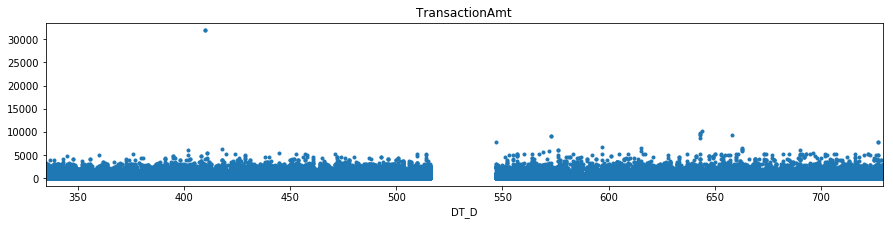

In [16]:
########################### TransactionAmt
i_cols = ['TransactionAmt']
periods = ['DT_D']

temp_df = pd.concat([train_df[['TransactionDT']+i_cols+periods], test_df[['TransactionDT']+i_cols+periods]])
for period in periods:
    for col in i_cols:
        for df in [temp_df]:
            df.set_index(period)[col].plot(style='.', title=col, figsize=(15, 3))
            plt.show()

# Clip Values
train_df['TransactionAmt'] = train_df['TransactionAmt'].clip(0,5000)
test_df['TransactionAmt']  = test_df['TransactionAmt'].clip(0,5000)

# Check if the Transaction Amount is common or not (we can use freq encoding here)
# In our dialog with a model we are telling to trust or not to these values   
train_df['TransactionAmt_check'] = np.where(train_df['TransactionAmt'].isin(test_df['TransactionAmt']), 1, 0)
test_df['TransactionAmt_check']  = np.where(test_df['TransactionAmt'].isin(train_df['TransactionAmt']), 1, 0)

# For our model current TransactionAmt is a noise
# https://www.kaggle.com/kyakovlev/ieee-check-noise
# (even if features importances are telling contrariwise)
# There are many unique values and model doesn't generalize well
# Lets do some aggregations
i_cols = ['TransactionAmt']
uids = ['card1','card2','card3','card5','uid','uid2','uid3','uid4','uid5','bank_type']
aggregations = ['mean','std']

# uIDs aggregations
train_df, test_df = uid_aggregation(train_df, test_df, i_cols, uids, aggregations)
 
# TransactionAmt Normalization
periods = ['DT_D','DT_W','DT_M']
for df in [train_df, test_df]:
    df = values_normalization(df, periods, i_cols)

# Product type
train_df['product_type'] = train_df['ProductCD'].astype(str)+'_'+train_df['TransactionAmt'].astype(str)
test_df['product_type'] = test_df['ProductCD'].astype(str)+'_'+test_df['TransactionAmt'].astype(str)

i_cols = ['product_type']
periods = ['DT_D','DT_W','DT_M']
train_df, test_df = timeblock_frequency_encoding(train_df, test_df, periods, i_cols, 
                                                 with_proportions=False, only_proportions=True)
train_df, test_df = frequency_encoding(train_df, test_df, i_cols, self_encoding=True)

# Small "hack" to transform distribution 
# (doesn't affect auc much, but I like it more)
# please see how distribution transformation can boost your score 
# (not our case but related)
# https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html
train_df['TransactionAmt'] = np.log1p(train_df['TransactionAmt'])
test_df['TransactionAmt'] = np.log1p(test_df['TransactionAmt'])

In [122]:
features = [x for x in train_df.columns if x not in remove_features and train_df[x].dtype != 'object'
           ]
print(len(features))
_, model = local_valid(train_df, 'isFraud', features, lgb_params, return_model=True)

711
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.955716	valid_1's auc: 0.899667
[200]	training's auc: 0.975678	valid_1's auc: 0.912911
[300]	training's auc: 0.98774	valid_1's auc: 0.921018
[400]	training's auc: 0.994089	valid_1's auc: 0.926342
[500]	training's auc: 0.997333	valid_1's auc: 0.929194
[600]	training's auc: 0.99885	valid_1's auc: 0.930784
[700]	training's auc: 0.999534	valid_1's auc: 0.931761
[800]	training's auc: 0.999824	valid_1's auc: 0.932743
[900]	training's auc: 0.999937	valid_1's auc: 0.933045
[1000]	training's auc: 0.999982	valid_1's auc: 0.933355
[1100]	training's auc: 0.999996	valid_1's auc: 0.933685
[1200]	training's auc: 0.999999	valid_1's auc: 0.934018
[1300]	training's auc: 1	valid_1's auc: 0.93405
[1400]	training's auc: 1	valid_1's auc: 0.934111
Early stopping, best iteration is:
[1379]	training's auc: 1	valid_1's auc: 0.93416


In [17]:
########################### C Columns
i_cols = ['C'+str(i) for i in range(1,15)]

####### Global Self frequency encoding
# self_encoding=False because 
# I want to keep original values
train_df, test_df = frequency_encoding(train_df, test_df, i_cols, self_encoding=False)

####### Clip max values
for df in [train_df, test_df]:
    for col in i_cols:
        max_value = train_df[train_df['DT_M']==train_df['DT_M'].max()][col].max()
        df[col] = df[col].clip(None,max_value) 

In [127]:
features = [x for x in train_df.columns if x not in remove_features and train_df[x].dtype != 'object'
           ]
print(len(features))
_, model = local_valid(train_df, 'isFraud', features, lgb_params, return_model=True)

725
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.955197	valid_1's auc: 0.898273
[200]	training's auc: 0.975762	valid_1's auc: 0.911662
[300]	training's auc: 0.987743	valid_1's auc: 0.920209
[400]	training's auc: 0.994201	valid_1's auc: 0.925473
[500]	training's auc: 0.997404	valid_1's auc: 0.928602
[600]	training's auc: 0.998903	valid_1's auc: 0.930172
[700]	training's auc: 0.999554	valid_1's auc: 0.930981
[800]	training's auc: 0.999826	valid_1's auc: 0.931772
[900]	training's auc: 0.999941	valid_1's auc: 0.932091
[1000]	training's auc: 0.999983	valid_1's auc: 0.932456
[1100]	training's auc: 0.999996	valid_1's auc: 0.932778
[1200]	training's auc: 0.999999	valid_1's auc: 0.933088
[1300]	training's auc: 1	valid_1's auc: 0.933147
Early stopping, best iteration is:
[1281]	training's auc: 1	valid_1's auc: 0.933222


In [18]:
for df in [train_identity, test_identity]:
    ########################### Device info
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    df['DeviceInfo_device'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['DeviceInfo_version'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
    ########################### Device info 2
    df['id_30'] = df['id_30'].fillna('unknown_device').str.lower()
    df['id_30_device'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['id_30_version'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
    ########################### Browser
    df['id_31'] = df['id_31'].fillna('unknown_device').str.lower()
    df['id_31_device'] = df['id_31'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    
########################### Merge Identity columns
temp_df = train_df[['TransactionID']]
temp_df = temp_df.merge(train_identity, on=['TransactionID'], how='left')
del temp_df['TransactionID']
train_df = pd.concat([train_df,temp_df], axis=1)
    
temp_df = test_df[['TransactionID']]
temp_df = temp_df.merge(test_identity, on=['TransactionID'], how='left')
del temp_df['TransactionID']
test_df = pd.concat([test_df,temp_df], axis=1)

i_cols = [
          'DeviceInfo','DeviceInfo_device','DeviceInfo_version',
          'id_30','id_30_device','id_30_version',
          'id_31','id_31_device',
          'id_33',
         ]

####### Global Self frequency encoding
# self_encoding=True because 
# we don't need original values anymore
train_df, test_df = frequency_encoding(train_df, test_df, i_cols, self_encoding=True)

In [129]:
features = [x for x in train_df.columns if x not in remove_features and train_df[x].dtype != 'object'
           ]
print(len(features))
_, model = local_valid(train_df, 'isFraud', features, lgb_params, return_model=True)

771
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.955814	valid_1's auc: 0.897945
[200]	training's auc: 0.97629	valid_1's auc: 0.91215
[300]	training's auc: 0.98843	valid_1's auc: 0.921438
[400]	training's auc: 0.994614	valid_1's auc: 0.926923
[500]	training's auc: 0.997634	valid_1's auc: 0.929625
[600]	training's auc: 0.999047	valid_1's auc: 0.931583
[700]	training's auc: 0.999636	valid_1's auc: 0.932707
[800]	training's auc: 0.999872	valid_1's auc: 0.933307
[900]	training's auc: 0.999961	valid_1's auc: 0.934055
[1000]	training's auc: 0.999991	valid_1's auc: 0.934505
[1100]	training's auc: 0.999999	valid_1's auc: 0.934926
[1200]	training's auc: 1	valid_1's auc: 0.935066
[1300]	training's auc: 1	valid_1's auc: 0.935246
[1400]	training's auc: 1	valid_1's auc: 0.935233
Early stopping, best iteration is:
[1349]	training's auc: 1	valid_1's auc: 0.935315


In [19]:
########################### ProductCD and M4 Target mean
# As we already have frequency encoded columns
# We can have different global transformation on them
# Target mean?
# We will transform original values as we don't need them
# Leakage over folds?
# Yes, we will have some,
# But in the same time we already have leakage from 
# V columns and card1->card6 columns
# So, no much harm here
for col in ['ProductCD','M4']:
    temp_dict = train_df.groupby([col])[TARGET].agg(['mean']).reset_index().rename(
                                                        columns={'mean': col+'_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col+'_target_mean'].to_dict()

    train_df[col] = train_df[col].map(temp_dict)
    test_df[col]  = test_df[col].map(temp_dict)

In [20]:
########################### Encode Str columns
# For all such columns (probably not)
# we already did frequency encoding (numeric feature)
# so we will use astype('category') here
for col in list(train_df):
    if train_df[col].dtype=='O':
        print(col)
        train_df[col] = train_df[col].fillna('unseen_before_label')
        test_df[col]  = test_df[col].fillna('unseen_before_label')
        
        train_df[col] = train_df[col].astype(str)
        test_df[col] = test_df[col].astype(str)
        
        le = LabelEncoder()
        le.fit(list(train_df[col])+list(test_df[col]))
        train_df[col] = le.transform(train_df[col])
        test_df[col]  = le.transform(test_df[col])
        
        train_df[col] = train_df[col].astype('category')
        test_df[col] = test_df[col].astype('category')

P_emaildomain
R_emaildomain
uid
uid2
uid3
uid4
uid5
bank_type
DeviceType


In [134]:
features = [x for x in train_df.columns if x not in remove_features and train_df[x].dtype != 'object'
           ]
print(len(features))
_, model = local_valid(train_df, 'isFraud', features, lgb_params, return_model=True)

774
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.956621	valid_1's auc: 0.899567
[200]	training's auc: 0.977357	valid_1's auc: 0.914579
[300]	training's auc: 0.988985	valid_1's auc: 0.92339
[400]	training's auc: 0.994901	valid_1's auc: 0.928576
[500]	training's auc: 0.997778	valid_1's auc: 0.931536
[600]	training's auc: 0.999096	valid_1's auc: 0.933239
[700]	training's auc: 0.99966	valid_1's auc: 0.934239
[800]	training's auc: 0.99988	valid_1's auc: 0.934991
[900]	training's auc: 0.999963	valid_1's auc: 0.935396
[1000]	training's auc: 0.999991	valid_1's auc: 0.93578
[1100]	training's auc: 0.999999	valid_1's auc: 0.936011
[1200]	training's auc: 1	valid_1's auc: 0.936337
[1300]	training's auc: 1	valid_1's auc: 0.936624
[1400]	training's auc: 1	valid_1's auc: 0.936499
Early stopping, best iteration is:
[1303]	training's auc: 1	valid_1's auc: 0.936641


In [138]:
df = train_df
n = df.shape[0]
valid_idx = list(df.index[int(n*0.8):])
X_val, y_val = df.loc[valid_idx, features], df.loc[valid_idx, TARGET]

per_res = permutation_importance_lgb(model, X_val, y_val, roc_auc_score, features[425:713], verbose=True)

Base score 0.93671
column: uid_D1_mean - 0.93672
column: uid_D1_std - 0.93671
column: uid2_D1_mean - 0.9367
column: uid2_D1_std - 0.9367
column: uid3_D1_mean - 0.93676
column: uid3_D1_std - 0.93678
column: uid4_D1_mean - 0.93671
column: uid4_D1_std - 0.93666
column: uid5_D1_mean - 0.93675
column: uid5_D1_std - 0.93674
column: bank_type_D1_mean - 0.93673
column: bank_type_D1_std - 0.93673
column: uid_D2_mean - 0.93669
column: uid_D2_std - 0.93668
column: uid2_D2_mean - 0.9367
column: uid2_D2_std - 0.93656
column: uid3_D2_mean - 0.93679
column: uid3_D2_std - 0.93662
column: uid4_D2_mean - 0.93643
column: uid4_D2_std - 0.93657
column: uid5_D2_mean - 0.93658
column: uid5_D2_std - 0.93657
column: bank_type_D2_mean - 0.93671
column: bank_type_D2_std - 0.93677
column: uid_D3_mean - 0.93673
column: uid_D3_std - 0.93661
column: uid2_D3_mean - 0.93673
column: uid2_D3_std - 0.93652
column: uid3_D3_mean - 0.93671
column: uid3_D3_std - 0.93671
column: uid4_D3_mean - 0.93643
column: uid4_D3_std - 0.

column: D14_DT_M_std_score - 0.9367
column: D15_DT_M_min_max - 0.93655
column: D15_DT_M_std_score - 0.93653
column: D1_scaled - 0.93595
column: D2_scaled - 0.93459
column: TransactionAmt_check - 0.93671
column: card1_TransactionAmt_mean - 0.93663
column: card1_TransactionAmt_std - 0.9367
column: card2_TransactionAmt_mean - 0.93651
column: card2_TransactionAmt_std - 0.93667
column: card3_TransactionAmt_mean - 0.93675
column: card3_TransactionAmt_std - 0.93672
column: card5_TransactionAmt_mean - 0.93662
column: card5_TransactionAmt_std - 0.93669
column: uid_TransactionAmt_mean - 0.93673
column: uid_TransactionAmt_std - 0.93669
column: uid2_TransactionAmt_mean - 0.93653
column: uid2_TransactionAmt_std - 0.9367
column: uid3_TransactionAmt_mean - 0.93654
column: uid3_TransactionAmt_std - 0.93668
column: uid4_TransactionAmt_mean - 0.93667
column: uid4_TransactionAmt_std - 0.93671
column: uid5_TransactionAmt_mean - 0.93663
column: uid5_TransactionAmt_std - 0.93664
column: bank_type_Transactio

In [139]:
remove_features1 = remove_features + [x for x in per_res if x!= 'base_score' and  per_res[x]>=0.9367]
features = [x for x in train_df.columns if x not in remove_features1 and train_df[x].dtype != 'object'
          #  and not re.match('uid[0-9]{0,1}_DT_', x)
           ]
print(len(features))
_, model = local_valid(train_df, 'isFraud', features, lgb_params, return_model=True)

655
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.95558	valid_1's auc: 0.89924
[200]	training's auc: 0.976481	valid_1's auc: 0.913529
[300]	training's auc: 0.988257	valid_1's auc: 0.922833
[400]	training's auc: 0.994459	valid_1's auc: 0.928262
[500]	training's auc: 0.997521	valid_1's auc: 0.931148
[600]	training's auc: 0.998971	valid_1's auc: 0.932859
[700]	training's auc: 0.999603	valid_1's auc: 0.934166
[800]	training's auc: 0.999857	valid_1's auc: 0.934988
[900]	training's auc: 0.999955	valid_1's auc: 0.935522
[1000]	training's auc: 0.999989	valid_1's auc: 0.93602
[1100]	training's auc: 0.999998	valid_1's auc: 0.936379
[1200]	training's auc: 1	valid_1's auc: 0.936601
[1300]	training's auc: 1	valid_1's auc: 0.936892
[1400]	training's auc: 1	valid_1's auc: 0.937034
Early stopping, best iteration is:
[1370]	training's auc: 1	valid_1's auc: 0.936953


In [140]:
remove_features1 = remove_features + [x for x in per_res if x!= 'base_score' and  per_res[x]>=0.9366]
features = [x for x in train_df.columns if x not in remove_features1 and train_df[x].dtype != 'object'
          #  and not re.match('uid[0-9]{0,1}_DT_', x)
           ]
print(len(features))
_, model = local_valid(train_df, 'isFraud', features, lgb_params, return_model=True)

537
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.952138	valid_1's auc: 0.89808
[200]	training's auc: 0.973643	valid_1's auc: 0.912771
[300]	training's auc: 0.986082	valid_1's auc: 0.922297
[400]	training's auc: 0.992921	valid_1's auc: 0.928216
[500]	training's auc: 0.996648	valid_1's auc: 0.931149
[600]	training's auc: 0.998522	valid_1's auc: 0.932864
[700]	training's auc: 0.999388	valid_1's auc: 0.934126
[800]	training's auc: 0.999761	valid_1's auc: 0.935002
[900]	training's auc: 0.999916	valid_1's auc: 0.935646
[1000]	training's auc: 0.999974	valid_1's auc: 0.936198
[1100]	training's auc: 0.999994	valid_1's auc: 0.936469
[1200]	training's auc: 0.999999	valid_1's auc: 0.936584
[1300]	training's auc: 1	valid_1's auc: 0.936951
[1400]	training's auc: 1	valid_1's auc: 0.937082
[1500]	training's auc: 1	valid_1's auc: 0.937367
Early stopping, best iteration is:
[1494]	training's auc: 1	valid_1's auc: 0.937331


In [148]:
remove_features += [x for x in per_res if x!= 'base_score' and  per_res[x]>=0.9366]
features = [x for x in train_df.columns if x not in remove_features and train_df[x].dtype != 'object'
          #  and not re.match('uid[0-9]{0,1}_DT_', x)
           ]
params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators': 1900,
                    'max_bin':255,
                    'verbose':100,
                    'seed': SEED,
                }
X_train = train_df[features]
y_train = train_df['isFraud']
model = lgb.LGBMClassifier(**params)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train)], eval_metric='auc', verbose=100)

[100]	training's auc: 0.942788
[200]	training's auc: 0.96878
[300]	training's auc: 0.983268
[400]	training's auc: 0.99096
[500]	training's auc: 0.995133
[600]	training's auc: 0.997398
[700]	training's auc: 0.99862
[800]	training's auc: 0.999247
[900]	training's auc: 0.999587
[1000]	training's auc: 0.99977
[1100]	training's auc: 0.999872
[1200]	training's auc: 0.999931
[1300]	training's auc: 0.999962
[1400]	training's auc: 0.999981
[1500]	training's auc: 0.99999
[1600]	training's auc: 0.999995
[1700]	training's auc: 0.999998
[1800]	training's auc: 0.999999
[1900]	training's auc: 1


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
        importance_type='split', learning_rate=0.01, max_bin=255,
        max_depth=-1, metric='auc', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=1900,
        n_jobs=-1, num_leaves=256, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, seed=42, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1, tree_learner='serial',
        verbose=100)

In [150]:
import pickle
test_df = pickle.load(open('../input/df_test_baseline.pkl', 'rb'))
test_df.shape

(506691, 806)

In [151]:
test_df['isFraud'] = model.predict_proba(test_df[features])[:, 1]

In [153]:
test_df[['TransactionID', 'isFraud']].to_csv('../baseline_0914.csv', index=False)